The purpose of the notebook is to train a graph network for predicting the shortest path between two nodes in a graph.

The network is trained to label the nodes and the edges of the shortest path, given the start and the end nodes.

#### Geographical thresholded graph

The geographical threshold graph model places n nodes uniformly at random in a rectangular domain. Each node u is assigned a weight $w_u$. Two nodes u and v are joined by an edge if

$$
w_u+w_v\gt \theta \ r^{\alpha}
$$

where r is the Euclidean distance between u and v and $\theta$, $\alpha$ are parameters.


In [1]:
import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import random as rand
import sonnet as snt

import pprint as pp
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.


def pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  #intertools.tee returns two iterable 
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

def set_diff(seq0, seq1):
  """Return the set difference between 2 sequences as a list."""
  return list(set(seq0) - set(seq1))

def to_one_hot(indices, max_value, axis=-1):
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot

def get_node_dict(graph, attr):
  """Return a `dict` of node:attribute pairs from a graph."""
  return {k: v[attr] for k, v in graph.nodes.items()}

def generate_graph(rand,
                   num_nodes_min_max,
                   dimensions=2,
                   theta=1000.0,
                   rate=1.0):
  """Creates a connected graph.

  The graphs are geographic threshold graphs, but with added edges via a
  minimum spanning tree algorithm, to ensure all nodes are connected.

  Args:
    rand: A random seed for the graph generator. Default= None.
    num_nodes_min_max: A sequence [lower, upper) number of nodes per graph.
    dimensions: (optional) An `int` number of dimensions for the positions.
      Default= 2.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Large values (1000+) make mostly trees. Try
      20-60 for good non-trees. Default=1000.0.
    rate: (optional) A rate parameter for the node weight exponential sampling
      distribution. Default= 1.0.

  Returns:
    The graph.
  """
  # Sample num_nodes.
  num_nodes = rand.randint(*num_nodes_min_max)

  # Create geographic threshold graph.
  #pos_array returns the position of the node in the rectangular domain
  pos_array = rand.uniform(size=(num_nodes, dimensions))
  #pos contains the node and the position in the rectangular domain
  pos = dict(enumerate(pos_array))
  #weight contains the node and the weight sampled from an exponential distribution
  weight = dict(enumerate(rand.exponential(rate, size=num_nodes)))

  geo_graph = nx.geographical_threshold_graph(
      num_nodes, theta, pos=pos, weight=weight)

  # Create minimum spanning tree across geo_graph's nodes.
  distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
  i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
  weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
  mst_graph = nx.Graph()
  mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
  mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
  
  # Put geo_graph's node attributes into the mst_graph.
  for i in mst_graph.nodes():
    mst_graph.nodes[i].update(geo_graph.nodes[i])

  # Compose the graphs.
  combined_graph = nx.compose_all((mst_graph, geo_graph.copy()))
  # Put all distance weights into edge attributes.
  for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])
  return combined_graph, mst_graph, geo_graph


In [3]:
rand = np.random.RandomState(seed=1)

In [4]:
pos_array = rand.uniform(size=(10, 2))

In [5]:
pos_array

array([[4.17022005e-01, 7.20324493e-01],
       [1.14374817e-04, 3.02332573e-01],
       [1.46755891e-01, 9.23385948e-02],
       [1.86260211e-01, 3.45560727e-01],
       [3.96767474e-01, 5.38816734e-01],
       [4.19194514e-01, 6.85219500e-01],
       [2.04452250e-01, 8.78117436e-01],
       [2.73875932e-02, 6.70467510e-01],
       [4.17304802e-01, 5.58689828e-01],
       [1.40386939e-01, 1.98101489e-01]])

In [6]:
#dictinary containing the positions of all the nodes
pos = dict(enumerate(pos_array))

In [7]:
pos

{0: array([0.417022  , 0.72032449]),
 1: array([1.14374817e-04, 3.02332573e-01]),
 2: array([0.14675589, 0.09233859]),
 3: array([0.18626021, 0.34556073]),
 4: array([0.39676747, 0.53881673]),
 5: array([0.41919451, 0.6852195 ]),
 6: array([0.20445225, 0.87811744]),
 7: array([0.02738759, 0.67046751]),
 8: array([0.4173048 , 0.55868983]),
 9: array([0.14038694, 0.19810149])}

In [8]:
#dictionaru containing the weights of the nodes
weight = dict(enumerate(rand.exponential(1, size=10)))

In [9]:
weight

{0: 1.6131677028403504,
 1: 3.4502272097097024,
 2: 0.37603861290897017,
 3: 1.1787034984431248,
 4: 2.090616973214474,
 5: 2.250055865972534,
 6: 0.08887953331090477,
 7: 0.03983787812260575,
 8: 0.18612528528308295,
 9: 2.1049029778605255}

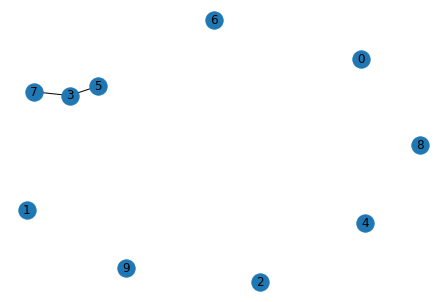

In [10]:
G = nx.geographical_threshold_graph(10, 50)
nx.draw(G,with_labels=True)

In [11]:
#pairwise distance between the points
spatial.distance.pdist(pos_array)

array([0.59036363, 0.68367394, 0.44011236, 0.18263437, 0.03517215,
       0.2647348 , 0.39281127, 0.16163491, 0.59096855, 0.25612732,
       0.19109931, 0.46179913, 0.56765356, 0.61096823, 0.36914382,
       0.48965998, 0.17475844, 0.25628507, 0.51171136, 0.65248032,
       0.78789419, 0.5903235 , 0.53914765, 0.10595449, 0.28576422,
       0.41185734, 0.53286734, 0.36166964, 0.31433361, 0.15442987,
       0.14811057, 0.39001296, 0.39213955, 0.02857834, 0.42640105,
       0.28865872, 0.39208454, 0.12654378, 0.56126431, 0.27289262,
       0.3838492 , 0.68302712, 0.40562258, 0.48569384, 0.45465091])

In [12]:
distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))

In [13]:
#return the distance between one node and all the others
distances

array([[0.        , 0.59036363, 0.68367394, 0.44011236, 0.18263437,
        0.03517215, 0.2647348 , 0.39281127, 0.16163491, 0.59096855],
       [0.59036363, 0.        , 0.25612732, 0.19109931, 0.46179913,
        0.56765356, 0.61096823, 0.36914382, 0.48965998, 0.17475844],
       [0.68367394, 0.25612732, 0.        , 0.25628507, 0.51171136,
        0.65248032, 0.78789419, 0.5903235 , 0.53914765, 0.10595449],
       [0.44011236, 0.19109931, 0.25628507, 0.        , 0.28576422,
        0.41185734, 0.53286734, 0.36166964, 0.31433361, 0.15442987],
       [0.18263437, 0.46179913, 0.51171136, 0.28576422, 0.        ,
        0.14811057, 0.39001296, 0.39213955, 0.02857834, 0.42640105],
       [0.03517215, 0.56765356, 0.65248032, 0.41185734, 0.14811057,
        0.        , 0.28865872, 0.39208454, 0.12654378, 0.56126431],
       [0.2647348 , 0.61096823, 0.78789419, 0.53286734, 0.39001296,
        0.28865872, 0.        , 0.27289262, 0.3838492 , 0.68302712],
       [0.39281127, 0.36914382, 0.5903235

In [14]:
 i_, j_ = np.meshgrid(range(10), range(10), indexing="ij")

In [16]:
i_

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

In [17]:
j_

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [18]:
#return a copy 
# if we modify it the original array will not be modified 
i_.flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [19]:
#return a view 
# if we modify it al the original array will be modified
# this one is faster since no menory is copied
i_.ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [20]:
weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
#returns a list of tuples (position_1, position_j,distance)

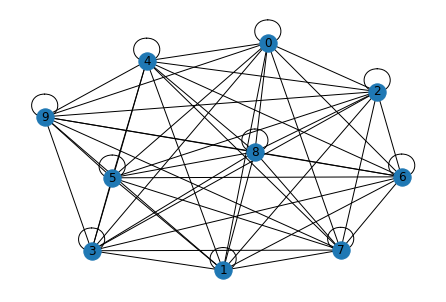

In [21]:
#complete graph because we add all possible combinations of nodes with edge value equal to 
#their distance
mst_graph = nx.Graph()
mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
nx.draw(mst_graph,with_labels=True)

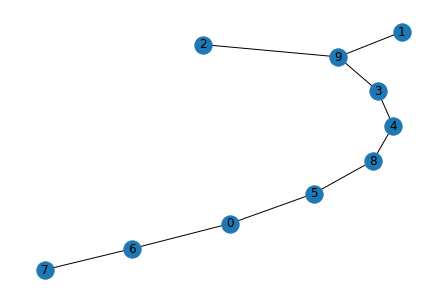

In [22]:
# this one return the minimum spanning tree ,
# a minimum spanning tree is a subgraph of the graph with the minumum sum of the edge weights
mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
nx.draw(mst_graph,with_labels=True)


In [23]:
mst_graph.edges().data()

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447})])

In [24]:
# union of all graphs , unions of the node sets and edge sets
# combine minumum spanning tree with geographical thresholded graph to produce
# a connected graph  
combined_graph = nx.compose_all((mst_graph, G.copy()))

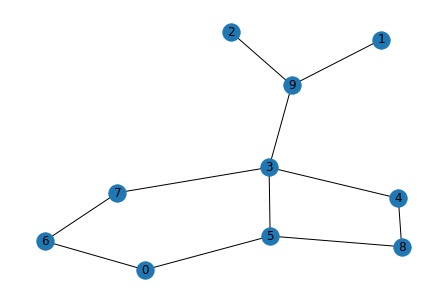

In [25]:
nx.draw(combined_graph,with_labels=True)

In [26]:
combined_graph.edges.data()
# all the edges present in geo_graph have no value ({}) all the others 
# have the value of the distance present in the mst_graph
# in general if a graph attribute is present in multiple graphs, then the value from the last graph
# in the list with that attribute is used

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (3, 5, {}), (3, 7, {}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447})])

In [27]:
# the empty values are filled with the distances present in the mst_graph

for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])

In [28]:
combined_graph.edges.data()

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (3, 5, {'distance': 0.4118573440430331}), (3, 7, {'distance': 0.3616696372860891}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447})])

In [29]:
def add_shortest_path(rand, graph, min_length=1):
  """Samples a shortest path from A to B and adds attributes to indicate it.

  Args:
    rand: A random seed for the graph generator. Default= None.
    graph: A `nx.Graph`.
    min_length: (optional) An `int` minimum number of edges in the shortest
      path. Default= 1.

  Returns:
    The `nx.DiGraph` with the shortest path added.

  Raises:
    ValueError: All shortest paths are below the minimum length
  """
  # Map from node pairs to the length of their shortest path.
  pair_to_length_dict = {}
  # pair_to_length_dict={(1,3):4,(1,9):6,,,,}

  try:
    # This is for compatibility with older networkx.
    lengths = nx.all_pairs_shortest_path_length(graph).items()
  except AttributeError:
    # This is for compatibility with newer networkx.
    lengths = list(nx.all_pairs_shortest_path_length(graph))
    
  for x, yy in lengths:
    for y, l in yy.items():
      if l >= min_length:
        pair_to_length_dict[x, y] = l
  if max(pair_to_length_dict.values()) < min_length:
    raise ValueError("All shortest paths are below the minimum length")
  
  # The node pairs which exceed the minimum length.
  # with list only the keys are returned 
  node_pairs = list(pair_to_length_dict)

  # Computes probabilities per pair, to enforce uniform sampling of each
  # shortest path lengths.
  # The counts of pairs per length.
  
  # counts contain the values of the shortest paths and how many times they appear 
  # in the dictionary
  counts = collections.Counter(pair_to_length_dict.values())
  prob_per_length = 1.0 / len(counts)
  probabilities = [
      prob_per_length / counts[pair_to_length_dict[x]] for x in node_pairs
  ]

  # Choose the start and end points.
  i = rand.choice(len(node_pairs), p=probabilities)
  start, end = node_pairs[i]

  #return a list of nodes in the shortest path from the source to the target
  path = nx.shortest_path(
      graph, source=start, target=end, weight=DISTANCE_WEIGHT_NAME)

  # Creates a directed graph, to store the directed path from start to end.
  # creates a deep copy of the graph 
  # instead DiGraph(graph) creates a shallow copy of the graph
  digraph = graph.to_directed()

  # Add the "start", "end", and "solution" attributes to the nodes and edges.
  digraph.add_node(start, start=True)
  digraph.add_node(end, end=True)
  digraph.add_nodes_from(set_diff(digraph.nodes(), [start]), start=False)
  digraph.add_nodes_from(set_diff(digraph.nodes(), [end]), end=False)
  digraph.add_nodes_from(set_diff(digraph.nodes(), path), solution=False)
  digraph.add_nodes_from(path, solution=True)
  path_edges = list(pairwise(path))
  digraph.add_edges_from(set_diff(digraph.edges(), path_edges), solution=False)
  digraph.add_edges_from(path_edges, solution=True)

  return digraph

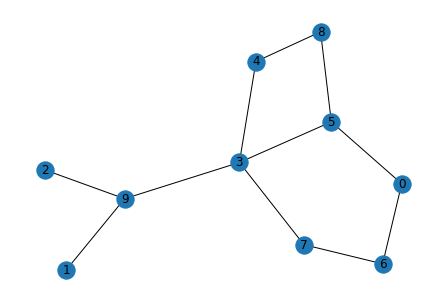

In [30]:
nx.draw(combined_graph,with_labels=True)

In [31]:
list(nx.all_pairs_shortest_path_length(combined_graph))
# computes the shostest path lenghts between all the nodes in G
# returns a list of (source, dictionary) where the dctionary
# is keyed by target and shortest path lenghts as the key value
 

[(0, {0: 0, 5: 1, 6: 1, 8: 2, 3: 2, 7: 2, 4: 3, 9: 3, 1: 4, 2: 4}),
 (1, {1: 0, 9: 1, 2: 2, 3: 2, 4: 3, 5: 3, 7: 3, 8: 4, 0: 4, 6: 4}),
 (2, {2: 0, 9: 1, 1: 2, 3: 2, 4: 3, 5: 3, 7: 3, 8: 4, 0: 4, 6: 4}),
 (3, {3: 0, 9: 1, 4: 1, 5: 1, 7: 1, 0: 2, 1: 2, 2: 2, 6: 2, 8: 2}),
 (4, {4: 0, 8: 1, 3: 1, 9: 2, 5: 2, 7: 2, 0: 3, 1: 3, 2: 3, 6: 3}),
 (5, {5: 0, 0: 1, 8: 1, 3: 1, 4: 2, 6: 2, 7: 2, 9: 2, 1: 3, 2: 3}),
 (6, {6: 0, 0: 1, 7: 1, 3: 2, 5: 2, 4: 3, 8: 3, 9: 3, 1: 4, 2: 4}),
 (7, {7: 0, 3: 1, 6: 1, 0: 2, 4: 2, 5: 2, 9: 2, 1: 3, 2: 3, 8: 3}),
 (8, {8: 0, 4: 1, 5: 1, 0: 2, 3: 2, 6: 3, 7: 3, 9: 3, 1: 4, 2: 4}),
 (9, {9: 0, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 7: 2, 8: 3, 0: 3, 6: 3})]

In [32]:
nx.shortest_path(combined_graph,0,3,weight=DISTANCE_WEIGHT_NAME)
#returns the list of the nodes in the shortest path between two nodes

[0, 5, 3]

In [33]:
rand = np.random.RandomState(seed=SEED)
combined_graph_short=add_shortest_path(rand,combined_graph)

In [34]:
combined_graph.nodes.data()

NodeDataView({0: {'weight': 0.04668224133474509, 'pos': [0.958965046908196, 0.3945767585939234]}, 1: {'weight': 0.38860853349880864, 'pos': [0.9895564183997511, 0.8985869950433653]}, 2: {'weight': 0.06453603317389489, 'pos': [0.8973525161734062, 0.5039436858084803]}, 3: {'weight': 2.3911902498874533, 'pos': [0.16534185681252178, 0.16867926628237295]}, 4: {'weight': 1.2048907866226048, 'pos': [0.2077179361491025, 0.5827225578389529]}, 5: {'weight': 1.3239724575813094, 'pos': [0.010097775247233987, 0.3083699682758313]}, 6: {'weight': 0.7935795347385665, 'pos': [0.2541977685275455, 0.8184286328678438]}, 7: {'weight': 0.031070319430937382, 'pos': [0.2955510227438569, 0.03342094634726467]}, 8: {'weight': 0.3870924878621907, 'pos': [0.4228128682568255, 0.3389502984504936]}, 9: {'weight': 1.2099912483269242, 'pos': [0.7554989031424677, 0.2109617856949777]}})

In [35]:
combined_graph_short.nodes.data()
# contains the same nodes but with more attributes
# 'start' if the node is the starting node of the shortest path
# 'end' if the node is the ending node of the shortest path
# 'solution' if the node belongs to the shortest path 

NodeDataView({0: {'weight': 0.04668224133474509, 'pos': [0.958965046908196, 0.3945767585939234], 'start': False, 'end': False, 'solution': False}, 1: {'weight': 0.38860853349880864, 'pos': [0.9895564183997511, 0.8985869950433653], 'start': False, 'end': False, 'solution': False}, 2: {'weight': 0.06453603317389489, 'pos': [0.8973525161734062, 0.5039436858084803], 'end': True, 'start': False, 'solution': True}, 3: {'weight': 2.3911902498874533, 'pos': [0.16534185681252178, 0.16867926628237295], 'start': True, 'end': False, 'solution': True}, 4: {'weight': 1.2048907866226048, 'pos': [0.2077179361491025, 0.5827225578389529], 'start': False, 'end': False, 'solution': False}, 5: {'weight': 1.3239724575813094, 'pos': [0.010097775247233987, 0.3083699682758313], 'start': False, 'end': False, 'solution': False}, 6: {'weight': 0.7935795347385665, 'pos': [0.2541977685275455, 0.8184286328678438], 'start': False, 'end': False, 'solution': False}, 7: {'weight': 0.031070319430937382, 'pos': [0.2955510

In [36]:
combined_graph.edges.data()

EdgeDataView([(0, 5, {'distance': 0.03517215283597537}), (0, 6, {'distance': 0.2647347985681034}), (1, 9, {'distance': 0.17475843592283455}), (2, 9, {'distance': 0.10595448724107487}), (3, 9, {'distance': 0.15442986762597377}), (3, 4, {'distance': 0.2857642243880516}), (3, 5, {'distance': 0.4118573440430331}), (3, 7, {'distance': 0.3616696372860891}), (4, 8, {'distance': 0.028578343718642082}), (5, 8, {'distance': 0.12654378252450532}), (6, 7, {'distance': 0.2728926243954447})])

In [37]:
combined_graph_short.edges.data()
#'solution' if the edge belongs to the shortest path

OutEdgeDataView([(0, 5, {'distance': 0.03517215283597537, 'solution': False}), (0, 6, {'distance': 0.2647347985681034, 'solution': False}), (1, 9, {'distance': 0.17475843592283455, 'solution': False}), (2, 9, {'distance': 0.10595448724107487, 'solution': False}), (3, 9, {'distance': 0.15442986762597377, 'solution': True}), (3, 4, {'distance': 0.2857642243880516, 'solution': False}), (3, 5, {'distance': 0.4118573440430331, 'solution': False}), (3, 7, {'distance': 0.3616696372860891, 'solution': False}), (4, 3, {'distance': 0.2857642243880516, 'solution': False}), (4, 8, {'distance': 0.028578343718642082, 'solution': False}), (5, 0, {'distance': 0.03517215283597537, 'solution': False}), (5, 8, {'distance': 0.12654378252450532, 'solution': False}), (5, 3, {'distance': 0.4118573440430331, 'solution': False}), (6, 0, {'distance': 0.2647347985681034, 'solution': False}), (6, 7, {'distance': 0.2728926243954447, 'solution': False}), (7, 6, {'distance': 0.2728926243954447, 'solution': False}), 

In [38]:
def graph_to_input_target(graph):
  """Returns 2 graphs with input and target feature vectors for training.

  Args:
    graph: An `nx.DiGraph` instance.

  Returns:
    The input `nx.DiGraph` instance.
    The target `nx.DiGraph` instance.

  Raises:
    ValueError: unknown node type
  """

  def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

  input_node_fields = ("pos", "weight", "start", "end")
  input_edge_fields = ("distance",)
  target_node_fields = ("solution",)
  target_edge_fields = ("solution",)

  input_graph = graph.copy()
  target_graph = graph.copy()

  solution_length = 0

  for node_index, node_feature in graph.nodes(data=True):

    #in input graph each node has as features the concatenation of its fields 
    input_graph.add_node(
        node_index, features=create_feature(node_feature, input_node_fields))

    #in target graph each node has as features a one hot vector 
    target_node = to_one_hot(
        create_feature(node_feature, target_node_fields).astype(int), 2)[0]
    target_graph.add_node(node_index, features=target_node)

    #keep track of the lenght of the shortest path 
    solution_length += int(node_feature["solution"])
  
  solution_length /= graph.number_of_nodes()
  
  for sender, receiver, features in graph.edges(data=True):
    
    input_graph.add_edge(
        sender, receiver, features=create_feature(features, input_edge_fields))
    
    # in the target graph each edge has as features a one hot vector
    # if it does not belongs to the shortest path 'solution'=False -> [1,0]
    # if it belongs to the shortest path 'solution'=True -> [0,1]
    target_edge = to_one_hot(
        create_feature(features, target_edge_fields).astype(int), 2)[0]
    target_graph.add_edge(sender, receiver, features=target_edge)

  input_graph.graph["features"] = np.array([0.0])
  target_graph.graph["features"] = np.array([solution_length], dtype=float)

  return input_graph, target_graph

In [39]:
def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

input_node_fields = ("pos", "weight", "start", "end")

for i,j in combined_graph_short.nodes(data=True):
    print(i)
    pp.pprint(j)
    print(create_feature(j, input_node_fields))
    break

# features 'pos' ,'weight', 'start' ,'end' are hstacked together

0
{'end': False,
 'pos': [0.958965046908196, 0.3945767585939234],
 'solution': False,
 'start': False,
 'weight': 0.04668224133474509}
[0.95896505 0.39457676 0.04668224 0.         0.        ]


In [40]:
target_node_fields = ("solution",)

for node_index,node_features in combined_graph_short.nodes(data=True):
    print(node_index)
    pp.pprint(node_features)
    print(create_feature(node_features, target_node_fields))
    print(to_one_hot(create_feature(node_features, target_node_fields).astype(int), 2)[0])
    break


0
{'end': False,
 'pos': [0.958965046908196, 0.3945767585939234],
 'solution': False,
 'start': False,
 'weight': 0.04668224133474509}
[0.]
[1. 0.]


In [41]:
print(to_one_hot([0],2))
print(to_one_hot([1],2))
print(to_one_hot(1,2))
print(to_one_hot(0,2))
print(to_one_hot(0,3))
print(to_one_hot(1,3))
print(to_one_hot(2,3))

[[1. 0.]]
[[0. 1.]]
[0. 1.]
[1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [42]:
input_graph,target_graph=graph_to_input_target(combined_graph_short)

In [43]:
def generate_networkx_graphs(rand, num_examples, num_nodes_min_max, theta):
  """Generate graphs for training.

  Args:
    rand: A random seed (np.RandomState instance).
    num_examples: Total number of graphs to generate.
    num_nodes_min_max: A 2-tuple with the [lower, upper) number of nodes per
      graph. The number of nodes for a graph is uniformly sampled within this
      range.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Default= the number of nodes.

  Returns:
    input_graphs: The list of input graphs.
    target_graphs: The list of output graphs.
    graphs: The list of generated graphs.
  """
  input_graphs = []
  target_graphs = []
  graphs = []
  for _ in range(num_examples):
    #keep only the combined graph
    graph = generate_graph(rand, num_nodes_min_max, theta=theta)[0]
    graph = add_shortest_path(rand, graph)
    #transform the created graph in input graph and target graph 
    input_graph, target_graph = graph_to_input_target(graph)
    input_graphs.append(input_graph)
    target_graphs.append(target_graph)
    graphs.append(graph)
  return input_graphs, target_graphs, graphs

In [44]:
def generate_data(rand,num_examples,num_nodes_min_max,theta):
    inp_graphs,out_graphs, _ =generate_networkx_graphs(rand,num_examples,num_nodes_min_max,theta)
    input_graphs = utils_tf.data_dicts_to_graphs_tuple([utils_np.networkx_to_data_dict(graph) for graph in inp_graphs])
    target_graphs = utils_tf.data_dicts_to_graphs_tuple([utils_np.networkx_to_data_dict(graph) for graph in out_graphs])
    return input_graphs, target_graphs

In [45]:
rand = np.random.RandomState(seed=SEED)
i,o=generate_data(rand,10,(3,10),20)

In [46]:
class GraphPlotter(object):

  def __init__(self, ax, graph, pos):
    self._ax = ax
    self._graph = graph
    self._pos = pos
    self._base_draw_kwargs = dict(G=self._graph, pos=self._pos, ax=self._ax)
    self._solution_length = None
    self._nodes = None
    self._edges = None
    self._start_nodes = None
    self._end_nodes = None
    self._solution_nodes = None
    self._intermediate_solution_nodes = None
    self._solution_edges = None
    self._non_solution_nodes = None
    self._non_solution_edges = None
    self._ax.set_axis_off()

  @property
  def solution_length(self):
    if self._solution_length is None:
      self._solution_length = len(self._solution_edges)
    return self._solution_length

  @property
  def nodes(self):
    if self._nodes is None:
      self._nodes = self._graph.nodes()
    return self._nodes

  @property
  def edges(self):
    if self._edges is None:
      self._edges = self._graph.edges()
    return self._edges

  @property
  def start_nodes(self):
    if self._start_nodes is None:
      self._start_nodes = [
          n for n in self.nodes if self._graph.nodes[n].get("start", False)
      ]
    return self._start_nodes

  @property
  def end_nodes(self):
    if self._end_nodes is None:
      self._end_nodes = [
          n for n in self.nodes if self._graph.nodes[n].get("end", False)
      ]
    return self._end_nodes

  @property
  def solution_nodes(self):
    if self._solution_nodes is None:
      self._solution_nodes = [
          n for n in self.nodes if self._graph.nodes[n].get("solution", False)
      ]
    return self._solution_nodes

  @property
  def intermediate_solution_nodes(self):
    if self._intermediate_solution_nodes is None:
      self._intermediate_solution_nodes = [
          n for n in self.nodes
          if self._graph.nodes[n].get("solution", False) and
          not self._graph.nodes[n].get("start", False) and
          not self._graph.nodes[n].get("end", False)
      ]
    return self._intermediate_solution_nodes

  @property
  def solution_edges(self):
    if self._solution_edges is None:
      self._solution_edges = [
          e for e in self.edges
          if self._graph.get_edge_data(e[0], e[1]).get("solution", False)
      ]
    return self._solution_edges

  @property
  def non_solution_nodes(self):
    if self._non_solution_nodes is None:
      self._non_solution_nodes = [
          n for n in self.nodes
          if not self._graph.nodes[n].get("solution", False)
      ]
    return self._non_solution_nodes

  @property
  def non_solution_edges(self):
    if self._non_solution_edges is None:
      self._non_solution_edges = [
          e for e in self.edges
          if not self._graph.get_edge_data(e[0], e[1]).get("solution", False)
      ]
    return self._non_solution_edges

  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs

  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)

  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  def draw_graph_with_solution(self,
                               node_size=200,
                               node_color=(0.4, 0.8, 0.4),
                               node_linewidth=1.0,
                               edge_width=1.0,
                               start_color="w",
                               end_color="k",
                               solution_node_linewidth=3.0,
                               solution_edge_width=3.0):
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    node_collections = {}
    # Plot start nodes.
    node_collections["start nodes"] = self.draw_nodes(
        nodelist=self.start_nodes,
        node_size=node_size,
        node_color=start_color,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=100)
    # Plot end nodes.
    node_collections["end nodes"] = self.draw_nodes(
        nodelist=self.end_nodes,
        node_size=node_size,
        node_color=end_color,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=90)
    # Plot intermediate solution nodes.
    if isinstance(node_color, dict):
      c = [node_color[n] for n in self.intermediate_solution_nodes]
    else:
      c = node_color
    node_collections["intermediate solution nodes"] = self.draw_nodes(
        nodelist=self.intermediate_solution_nodes,
        node_size=node_size,
        node_color=c,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=80)
    # Plot solution edges.
    node_collections["solution edges"] = self.draw_edges(
        edgelist=self.solution_edges, width=solution_edge_width, zorder=70)
    # Plot non-solution nodes.
    if isinstance(node_color, dict):
      c = [node_color[n] for n in self.non_solution_nodes]
    else:
      c = node_color
    node_collections["non-solution nodes"] = self.draw_nodes(
        nodelist=self.non_solution_nodes,
        node_size=node_size,
        node_color=c,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot non-solution edges.
    node_collections["non-solution edges"] = self.draw_edges(
        edgelist=self.non_solution_edges, width=edge_width, zorder=10)
    # Set title as solution length.
    self._ax.set_title("Solution length: {}".format(self.solution_length))
    return node_collections

C:\Users\calni\AppData\Local\Temp/ipykernel_22240/2852168730.py:119: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  isinstance(kwargs["node_color"], collections.Sequence) and


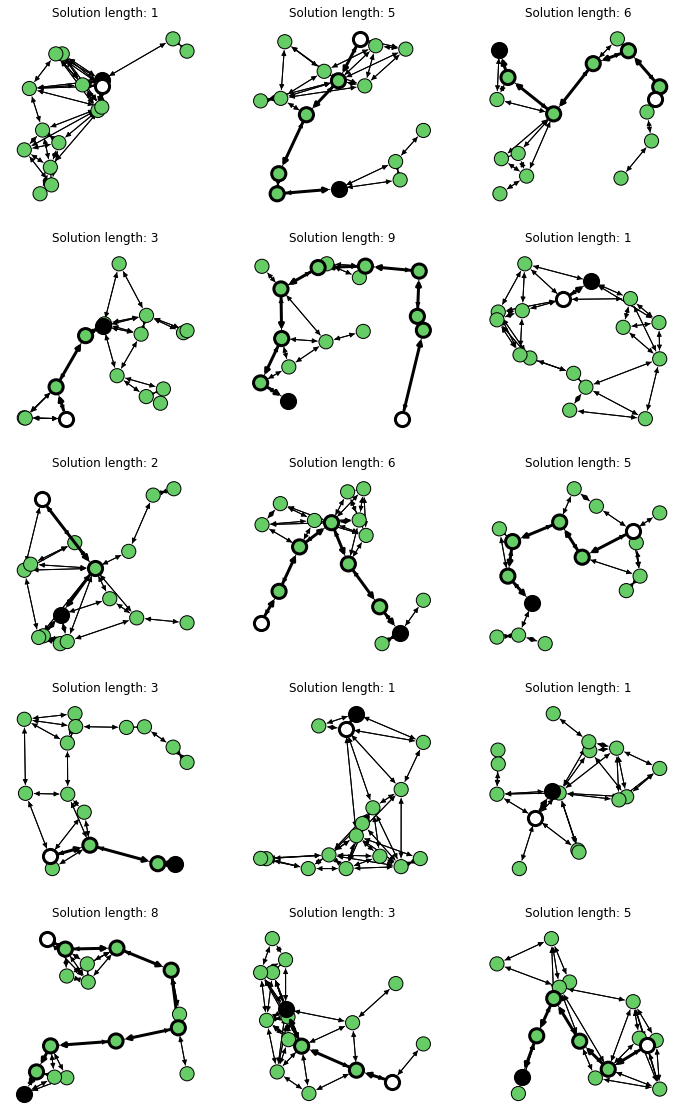

In [47]:
seed = 1  #@param{type: 'integer'}
rand = np.random.RandomState(seed=seed)

num_examples = 15  #@param{type: 'integer'}
# Large values (1000+) make trees. Try 20-60 for good non-trees.
theta = 20  #@param{type: 'integer'}
num_nodes_min_max = (16, 17)

input_graphs, target_graphs, graphs = generate_networkx_graphs(
    rand, num_examples, num_nodes_min_max, theta)

num = min(num_examples, 16)
w = 3
h = int(np.ceil(num / w))
fig = plt.figure(40, figsize=(w * 4, h * 4))
fig.clf()
for j, graph in enumerate(graphs):
  ax = fig.add_subplot(h, w, j + 1)
  pos = get_node_dict(graph, "pos")
  plotter = GraphPlotter(ax, graph, pos)
  plotter.draw_graph_with_solution()

## Training 

In [48]:
# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the shortest path labeled (using 2-element 1-hot vectors). We could have
# predicted the shortest path only by labeling either the nodes or edges, and
# that does work, but we decided to predict both to demonstrate the flexibility
# of graph nets' outputs.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to graphs which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on graphs with between 8-16 nodes.

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 3000
batch_size_tr = 32
batch_size_ge = 100
# Number of elements in each list is sampled uniformly from this range.
num_elements_min_max_tr = (8, 17)
num_elements_min_max_ge = (16, 33)

# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)

model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [49]:
def compute_accuracy(target, output, use_nodes=True, use_edges=False):
  """Calculate model accuracy.

  Returns the number of correctly predicted shortest path nodes and the number
  of completely solved graphs (100% correct predictions).

  Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.
    use_nodes: A `bool` indicator of whether to compute node accuracy or not.
    use_edges: A `bool` indicator of whether to compute edge accuracy or not.

  Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.

  Raises:
    ValueError: Nodes or edges (or both) must be used
  """
  if not use_nodes and not use_edges:
    raise ValueError("Nodes or edges (or both) must be used")
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  cs = []
  ss = []
  for td, od in zip(tdds, odds):
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)
    xe = np.argmax(td["edges"], axis=-1)
    ye = np.argmax(od["edges"], axis=-1)
    c = []
    if use_nodes:
      c.append(xn == yn)
    if use_edges:
      c.append(xe == ye)
    c = np.concatenate(c, axis=0)
    s = np.all(c)
    cs.append(c)
    ss.append(s)
  correct = np.mean(np.concatenate(cs, axis=0))
  solved = np.mean(np.stack(ss))
  return correct, solved


def create_loss(target_op, output_ops):
  loss_ops = [
      tf.compat.v1.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
      tf.compat.v1.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
      for output_op in output_ops
  ]
  return loss_ops

In [55]:
# Training.
def update_step(inputs_tr, targets_tr):
  with tf.GradientTape() as tape:
    outputs_tr = model(inputs_tr, num_processing_steps_tr)
    # Loss.
    loss_tr = create_loss(targets_tr, outputs_tr)
    loss_tr = tf.math.reduce_sum(loss_tr) / num_processing_steps_tr

  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return outputs_tr, loss_tr

In [52]:
@tf.function
def get_data():

    inputs_tr,targets_tr=generate_data(rand=rand,num_examples=batch_size_tr,num_nodes_min_max=num_elements_min_max_tr,theta=theta)
    #we don't have to set zero features because the graphs have all the kinds of features
    # node features, edge features, global features
    #inputs_tr = utils_tf.set_zero_edge_features(inputs_tr, 1)
    #inputs_tr = utils_tf.set_zero_global_features(inputs_tr, 1)

    inputs_ge,targets_ge=generate_data(rand=rand,num_examples=batch_size_ge,num_nodes_min_max=num_elements_min_max_ge,theta=theta)

    return inputs_tr,targets_tr,inputs_ge,targets_ge

In [53]:
# Get some example data that resembles the tensors that will be fed
# into update_step():
example_input_data, example_target_data = get_data()[:2]

# Get the input signature for that function by obtaining the specs
input_signature = [
  utils_tf.specs_from_graphs_tuple(example_input_data),
  utils_tf.specs_from_graphs_tuple(example_target_data)
]

# Compile the update function using the input signature for speedy code.
compiled_update_step = tf.function(update_step, input_signature=input_signature)
#compiled_update_step_2 = update_step(example_input_data,example_target_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node, got [<gast.gast.Expr object at 0x000001F5F32A6B80>, <gast.gast.ImportFrom object at 0x000001F5F3D37A90>, <gast.gast.ImportFrom object at 0x000001F5F3D376D0>, <gast.gast.Import object at 0x000001F5F3D372E0>, <gast.gast.Import object at 0x000001F5F3D376A0>, <gast.gast.ImportFrom object at 0x000001F5F3D370A0>, <gast.gast.Assign object at 0x000001F5F3D37F10>, <gast.gast.FunctionDef object at 0x000001F5F3D37EB0>]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node, got [<gast.gast.Expr object at 0x000001F5F32A6B80>, <gast.gast.ImportFrom object at 0x000001F5F3D37A90>, <

In [195]:
# Instantiate the model.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  (inputs_tr, targets_tr,
   inputs_ge, targets_ge) = get_data()

  outputs_tr, loss_tr = compiled_update_step(inputs_tr, targets_tr)

  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    outputs_ge = model(inputs_ge, num_processing_steps_ge)
    losss_ge = create_loss(targets_ge, outputs_ge)
    loss_ge = losss_ge[-1]

    # Replace the globals again to prevent exceptions.
    outputs_tr[-1] = outputs_tr[-1].replace(globals=None)
    targets_tr = targets_tr.replace(globals=None)

    correct_tr, solved_tr = compute_accuracy(
        utils_tf.nest_to_numpy(targets_tr),
        utils_tf.nest_to_numpy(outputs_tr[-1]))
    correct_ge, solved_ge = compute_accuracy(
        utils_tf.nest_to_numpy(targets_ge),
        utils_tf.nest_to_numpy(outputs_ge[-1]))
    elapsed = time.time() - start_time
    losses_tr.append(loss_tr.numpy())
    corrects_tr.append(correct_tr)
    solveds_tr.append(solved_tr)
    losses_ge.append(loss_ge.numpy())
    corrects_ge.append(correct_ge)
    solveds_ge.append(solved_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, "
          "Str {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
              iteration, elapsed, loss_tr.numpy(), loss_ge.numpy(),
              correct_tr, solved_tr, correct_ge, solved_ge))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)


c:\Users\calni\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_9/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_9/Reshape:0", shape=(None, 32), dtype=float64), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_9/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\calni\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/E

# 00000, T 21.1, Ltr 1.6927, Lge 1.2969, Ctr 0.5267, Str 0.0000, Cge 0.7665, Sge 0.0000
# 00507, T 41.0, Ltr 0.1370, Lge 1.1838, Ctr 0.9975, Str 0.9688, Cge 0.8062, Sge 0.0200
# 00994, T 61.0, Ltr 0.0845, Lge 1.3032, Ctr 1.0000, Str 1.0000, Cge 0.8340, Sge 0.0300
# 01513, T 81.1, Ltr 0.2747, Lge 0.6669, Ctr 0.9746, Str 0.7500, Cge 0.8000, Sge 0.0400
# 02063, T 101.1, Ltr 0.2489, Lge 0.7461, Ctr 0.9669, Str 0.6875, Cge 0.8422, Sge 0.0700
# 02613, T 121.1, Ltr 0.1089, Lge 0.9931, Ctr 0.9949, Str 0.9375, Cge 0.8447, Sge 0.0600


Text(0, 0.5, 'Fraction examples solved')

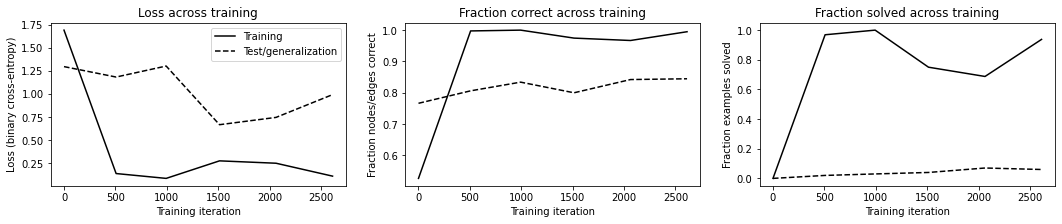

In [197]:
def softmax_prob_last_dim(x):  # pylint: disable=redefined-outer-name
  e = np.exp(x)
  return e[:, -1] / np.sum(e, axis=-1)


# Plot results curves.
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")